In [1]:
#import tensorrt as trt
from tensorrt_util import TensorrtModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from tqdm.auto import tqdm

from dataloading.ouster import OusterCrop, OusterNormalize, OusterDataset
from trainer import Trainer

%load_ext autoreload
%autoreload 2

In [2]:
def crop(img):
    fov = 256
    top = 54
    left = 256 - fov // 2
    height = 68
    width = 264

    img = img[:, 256:-256]
    img = img[top:top+height, left:left + width]
    return img

def normalise(img):
    return (img / 255)

def preprocess(img):
    img = crop(img)
    img = normalise(img)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:,:,0]
    img = np.expand_dims(img, axis=2)
    img = np.array(img, dtype=np.float32, order='C')
    img = preprocess(img)
    return img

def create_tensor(img):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    img_tensor = torch.FloatTensor(img).to(device).permute(2, 0, 1).unsqueeze(0)
    return img_tensor

In [18]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
valid_paths = [root_path / "2021-10-26-10-49-06_e2e_rec_ss20_elva", 
               root_path / "2021-10-26-11-08-59_e2e_rec_ss20_elva_back"]
validset = OusterDataset(valid_paths, channel="range")

Using only lidar channel range
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 11016
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 11094


(68, 264, 1)


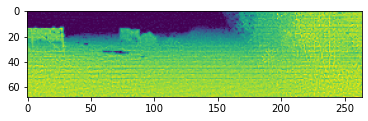

In [4]:
img = read_image(validset.frames.image_path.to_numpy()[0])
print(img.shape)
plt.imshow(img)

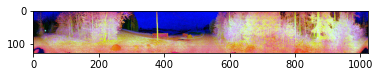

In [5]:
image = torchvision.io.read_image(validset.frames.image_path.to_numpy()[0])
plt.imshow(image.permute(1, 2, 0))

In [6]:
model_path = "models/20211123170437_lidar-ambience"
tensorrt_model = TensorrtModel(f"{model_path}/best.onnx")

Loading ONNX file from path models/20211123170437_lidar-ambience/best.onnx...
Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine from file models/20211123170437_lidar-ambience/best.onnx; this may take a while...
Completed creating Engine


In [7]:
tensorrt_predictions = []

for path in tqdm(validset.frames.image_path.to_numpy()):
    img = read_image(path)
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = np.array(img, dtype=np.float32, order='C')
    prediction = tensorrt_model.predict(img)
    tensorrt_predictions.append(prediction)

  0%|          | 0/22110 [00:00<?, ?it/s]

In [8]:
import torch
from network import PilotNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch_model = PilotNet(n_input_channels=1)
torch_model.load_state_dict(torch.load(f"{model_path}/best.pt"))
torch_model.to(device)
torch_model.eval()

PilotNet(
  (features): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Flatten(st

In [9]:
torch_predictions = []

for path in tqdm(validset.frames.image_path.to_numpy()):
    img = read_image(path)
    img_tensor = create_tensor(img)
    prediction = torch_model(img_tensor).squeeze(1)
    torch_predictions.append(prediction.item())

  0%|          | 0/22110 [00:00<?, ?it/s]

In [10]:
from torchvision import transforms

trainer = Trainer()
tr = transforms.Compose([OusterCrop(), OusterNormalize()])
validset_tr = OusterDataset(valid_paths, tr, channel="range")
validloader_tr = torch.utils.data.DataLoader(validset_tr, batch_size=64, shuffle=False,
                                         num_workers=16, pin_memory=True, persistent_workers=True)
torch_transforms_predictions = trainer.predict(torch_model, validloader_tr)

Using only lidar channel range
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 11016
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 11094


  0%|          | 0/346 [00:00<?, ?it/s]

In [11]:
from closed_loop_metrics import calculate_open_loop_metrics

calculate_open_loop_metrics(torch_transforms_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 8.126876492559342,
 'rmse': 23.424946652803726,
 'max': 511.1455924811144,
 'whiteness': 81.813576,
 'expert_whiteness': 22.923865138522743}

In [12]:
calculate_open_loop_metrics(tensorrt_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 8.12702144352721,
 'rmse': 23.425558966233755,
 'max': 511.11855390689567,
 'whiteness': 81.81116,
 'expert_whiteness': 22.923865138522743}

In [13]:
calculate_open_loop_metrics(torch_predictions, validset_tr.frames.steering_angle.to_numpy(), fps=10)

{'mae': 8.127142161718057,
 'rmse': 23.42609518387696,
 'max': 511.1528316509972,
 'whiteness': 81.79952248316677,
 'expert_whiteness': 22.923865138522743}

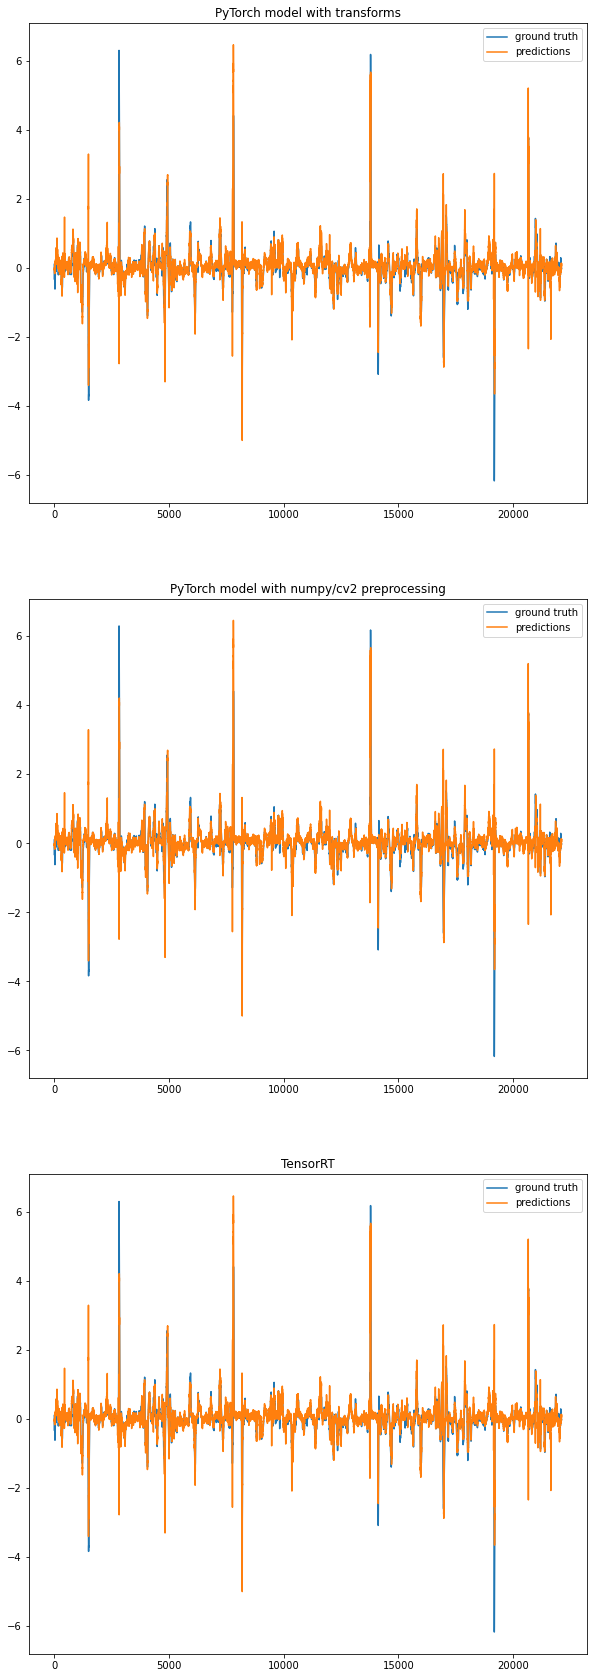

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

ax1.plot(validset.frames.steering_angle.to_numpy())
ax1.plot(torch_transforms_predictions)
ax1.legend(["ground truth", "predictions"])
ax1.set_title("PyTorch model with transforms")

ax2.plot(validset.frames.steering_angle.to_numpy())
ax2.plot(torch_predictions)
ax2.legend(["ground truth", "predictions"])
ax2.set_title("PyTorch model with numpy/cv2 preprocessing")

ax3.plot(validset.frames.steering_angle.to_numpy())
ax3.plot(tensorrt_predictions)
ax3.legend(["ground truth", "predictions"])
ax3.set_title("TensorRT");

In [21]:
import math
import cv2
import shutil
from skimage import io
import os
from moviepy.editor import ImageSequenceClip


def draw_steering_angle(frame, steering_angle, steering_wheel_radius, steering_position, size, color):
    steering_angle_rad = math.radians(steering_angle)
    x = steering_wheel_radius * np.cos(np.pi / 2 + steering_angle_rad)
    y = steering_wheel_radius * np.sin(np.pi / 2 + steering_angle_rad)
    cv2.circle(frame, (steering_position[0] + int(x), steering_position[1] - int(y)), size, color, thickness=-1)
    
def draw_frames(dataset, predicted_angles, temp_frames_folder):
    
    for frame_index, data in tqdm(enumerate(dataset), total=len(dataset)):
        frame = data["image"].permute(1, 2, 0).cpu().numpy()
        frame = cv2.merge([frame, frame, frame])
        true_angle = math.degrees(data["steering_angle"])
        pred_angle = math.degrees(predicted_angles[frame_index])
        
        cv2.putText(frame, 'True: {:.2f}deg'.format(true_angle), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2,
                    cv2.LINE_AA)
        cv2.putText(frame, 'Pred: {:.2f}deg'.format(pred_angle), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2,
                    cv2.LINE_AA)
    
        radius = 50
        steering_pos = (100, 128)
        cv2.circle(frame, steering_pos, radius, (255, 255, 255), 5)

        draw_steering_angle(frame, true_angle, radius, steering_pos, 9, (0, 255, 0))
        draw_steering_angle(frame, pred_angle, radius, steering_pos, 6, (255, 0, 0))
            
        io.imsave(f"{temp_frames_folder}/{frame_index + 1:05}.jpg", frame)
        

def convert_frames_to_video(frames_folder, output_video_path, fps=25):
    output_folder = Path(os.path.split(output_video_path)[:-1][0])
    output_folder.mkdir(parents=True, exist_ok=True)

    p = Path(frames_folder).glob('**/*.jpg')
    image_list = sorted([str(x) for x in p if x.is_file()])

    print("Creating video {}, FPS={}".format(frames_folder, fps))
    clip = ImageSequenceClip(image_list, fps=fps)
    clip.write_videofile(output_video_path)

In [22]:
video_name = "lidar_range"
temp_frames_folder = Path(f"./{video_name}_temp_frames")
shutil.rmtree(temp_frames_folder, ignore_errors=True)
temp_frames_folder.mkdir()

draw_frames(validset, tensorrt_predictions, temp_frames_folder)
output_video = f"output/{video_name}.mp4"
convert_frames_to_video(temp_frames_folder, output_video, fps=10.0)

shutil.rmtree(temp_frames_folder, ignore_errors=True)

  0%|          | 0/22110 [00:00<?, ?it/s]

Creating video lidar_range_temp_frames, FPS=10.0


t:  32%|██████████████████████████████████████████████████▌                                                                                                           | 6256/19533 [28:59<01:08, 192.64it/s, now=None]

Moviepy - Building video output/lidar_range.mp4.
Moviepy - Writing video output/lidar_range.mp4




t:   4%|██████▎                                                                                                                                                        | 871/22110 [00:03<01:37, 217.91it/s, now=None]


t:   8%|███████████▉                                                                                                                                                  | 1673/22110 [00:07<01:51, 183.36it/s, now=None]


t:  11%|█████████████████▊                                                                                                                                            | 2491/22110 [00:12<02:31, 129.87it/s, now=None]


t:  14%|█████████████████████▋                                                                                                                                        | 3040/22110 [00:16<02:58, 106.90it/s, now=None]


t:  16%|█████████████████████████▌                                                                                                                                    | 3579/22110 [00:20<02:50, 108.82it/s, now=None]


t:  19%|█████████████████████████████▎                                                                                                                                | 4103/22110 [00:24<02:44, 109.38it/s, now=None]


t:  21%|████████████████████████████████▍                                                                                                                             | 4547/22110 [00:28<02:52, 101.65it/s, now=None]


t:  23%|████████████████████████████████████▎                                                                                                                         | 5077/22110 [00:32<01:41, 167.60it/s, now=None]


t:  25%|████████████████████████████████████████▏                                                                                                                     | 5630/22110 [00:36<01:28, 186.52it/s, now=None]


t:  29%|█████████████████████████████████████████████▊                                                                                                                | 6405/22110 [00:41<01:11, 219.00it/s, now=None]


t:  32%|██████████████████████████████████████████████████▊                                                                                                           | 7102/22110 [00:45<01:47, 139.87it/s, now=None]


t:  34%|██████████████████████████████████████████████████████▍                                                                                                       | 7625/22110 [00:49<02:19, 103.90it/s, now=None]


t:  37%|██████████████████████████████████████████████████████████▌                                                                                                   | 8198/22110 [00:53<01:56, 119.00it/s, now=None]


t:  40%|██████████████████████████████████████████████████████████████▊                                                                                               | 8796/22110 [00:58<01:01, 217.39it/s, now=None]


t:  43%|████████████████████████████████████████████████████████████████████▍                                                                                         | 9576/22110 [01:02<01:05, 191.12it/s, now=None]


t:  46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 10274/22110 [01:06<00:57, 207.63it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 10995/22110 [01:10<01:01, 179.85it/s, now=None]


t:  53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11664/22110 [01:14<01:18, 132.43it/s, now=None]


t:  56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12425/22110 [01:18<00:48, 201.30it/s, now=None]


t:  60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 13212/22110 [01:22<00:40, 221.68it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 13899/22110 [01:26<00:49, 167.23it/s, now=None]


t:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 14500/22110 [01:31<01:12, 105.69it/s, now=None]


t:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15044/22110 [01:35<01:00, 117.67it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 15726/22110 [01:39<00:31, 204.09it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 16528/22110 [01:43<00:31, 176.38it/s, now=None]


t:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 17041/22110 [01:47<00:41, 122.45it/s, now=None]


t:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 17602/22110 [01:51<00:27, 164.54it/s, now=None]


t:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 18161/22110 [01:56<00:36, 107.11it/s, now=None]


t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 18720/22110 [02:00<00:21, 158.43it/s, now=None]


t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 19284/22110 [02:04<00:26, 105.77it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 19852/22110 [02:08<00:11, 195.55it/s, now=None]


t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 20635/22110 [02:12<00:12, 114.58it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 21409/22110 [02:16<00:03, 204.34it/s, now=None]


t:  32%|██████████████████████████████████████████████████▌                                                                                                           | 6256/19533 [31:19<01:08, 192.64it/s, now=None]

Moviepy - Done !
Moviepy - video ready output/lidar_range.mp4


In [ ]:
from IPython.display import HTML


HTML(f"""
<video width="640" height="480" controls>
  <source src="{output_video}" type="video/mp4">
</video>
""")

In [ ]:
output_video

t:  32%|██████████████████████████████████████████████████▌                                                                                                           | 6256/19533 [00:59<01:08, 192.64it/s, now=None]